In [1]:
# Autoreload changed python modules
%load_ext autoreload

In [2]:
import os, glob
import h5py # for loading .h5 files
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [3]:
plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams["axes.grid"] = False # don't show grid lines on plots by default
plt.rcParams['figure.figsize'] = (12, 16) # increase size of subplots

In [4]:
import cs230_project_utilities as utils
# make sure you have pywt: pip3 install PyWavelets --user

# Loading the data

In [5]:
# Location of directory H5Exports_AnimiX/ (downloaded from Olivier's link)
DATASET_DIRECTORY = '/dev/data'

In [6]:
# Find all the files in our dataset
h5_files = utils.automap.find_dataset_files(DATASET_DIRECTORY)

Found 134 .h5 files and 134 .txt files.


# Visualizing the data

In [7]:
##### Finally, we can see the raw data
sample_filename = list(h5_files.keys())[20]
print('Taking a look at file: {}'.format(sample_filename))
h5 = h5_files[sample_filename]['h5']
h5_data = utils.automap.read_h5_file(h5)
print(h5_data.keys())

images = h5_data['images']
magnitude = h5_data['magnitude']
phase = h5_data['phase']
classification = h5_data['classification']

# (Note: shape of magnitude and phase are different from image)
print(images.shape, magnitude.shape, phase.shape)
print(np.ndarray.flatten(classification))

Taking a look at file: 722_7761
dict_keys(['classification', 'images', 'magnitude', 'phase'])
(15, 256, 256) (15, 256, 256) (15, 256, 256)
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]


In [8]:
sample_index = np.argmax(classification)

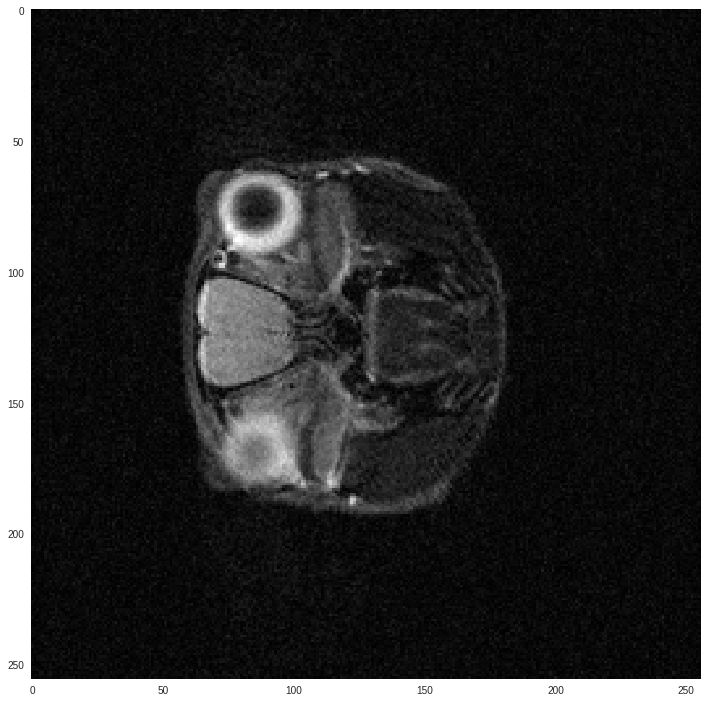

In [9]:
# Uncomment to view example image in dataset
utils.plot.imshowgray(images[sample_index])

In [10]:
# Construct FFT (k-space data) from magnitude and phase
fft = magnitude[sample_index] * np.exp(1j * phase[sample_index])

# Take the inverse FFT
ifft = utils.signal_processing.ifft_2D_centered(fft)

# Note: shape of magnitude and phase are different from image.
# Because of this, the reconstruction shape is different from the
# image shape and so we can't compare the image and reconstruction directly.
# How will we solve this?

# This check to make sure we are correctly combining magnitude and phase to construct the full, complex-valued FFT.
print('Error in FFT magnitude: {}'.format(utils.signal_processing.mean_square_error(np.abs(fft), magnitude[sample_index])))
print('Error in FFT phase: {}'.format(utils.signal_processing.mean_square_error(np.angle(fft), phase[sample_index])))

Error in FFT magnitude: 6.94545468855128e-20
Error in FFT phase: 5.084574094714262e-16


/home/ubuntu/cs230/code/MRI_reconstruction_example/cs230_project_utilities/plot.py:13: RuntimeWarning: divide by zero encountered in log10
  imshowgray(20 * np.log10(np.abs(fft)))


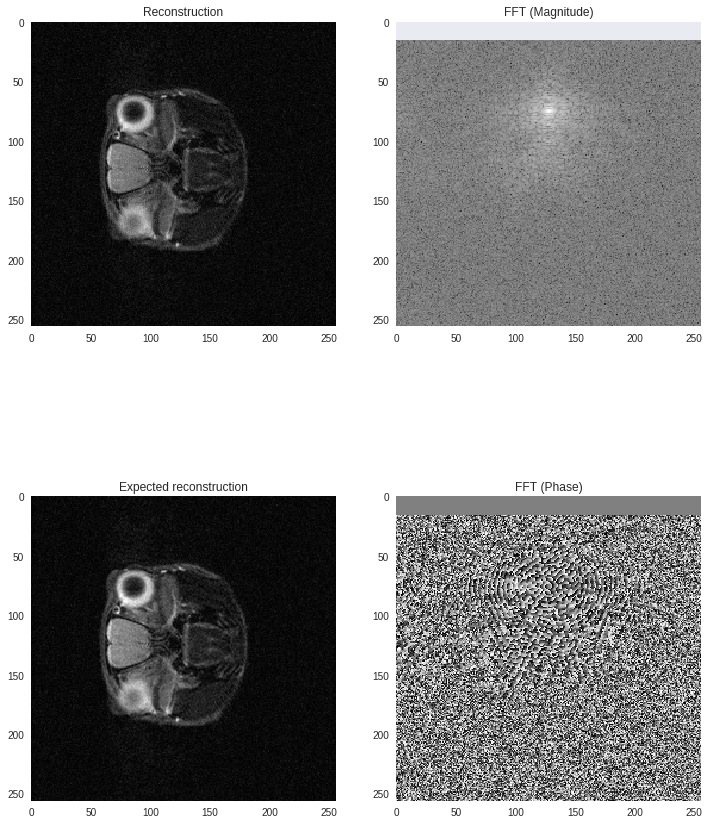

In [11]:
''' Uncomment to show plots.'''
plt.subplot(2, 2, 1)
plt.title('Reconstruction')
utils.plot.imshowgray(np.abs(ifft))
# 
plt.subplot(2, 2, 2)
plt.title('FFT (Magnitude)')
utils.plot.imshowfft(np.abs(fft))

plt.subplot(2, 2, 3)
plt.title('Expected reconstruction')
image = images[sample_index]
utils.plot.imshowgray(image)

plt.subplot(2, 2, 4)
plt.title('FFT (Phase)')
utils.plot.imshowgray(np.angle(fft))

# Automap Model

In [12]:
import tensorflow as tf

In [13]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [14]:
import keras
from keras.layers import Input,Conv2D, Conv2DTranspose, Dense, Reshape, Flatten
from keras.models import Model
from keras.optimizers import RMSprop
from keras import losses

Using TensorFlow backend.


In [15]:
tf.reset_default_graph()

In [16]:
def load_model():
    n_H, n_W = 256, 256
    X = Input((n_H, n_W, 2))
    conv_downsample1 = Conv2D(16, (4, 4), strides=(2, 2), activation='tanh', padding='same')(X)
    conv_downsample2 = Conv2D(4, (4, 4), strides=(1, 1), activation='tanh', padding='same')(conv_downsample1)
    conv_downsample3 = Conv2D(2, (4, 4), strides=(2, 2), activation='tanh', padding='same')(conv_downsample2)
    X1 = Flatten()(conv_downsample3)
    current_H, current_W = (256 // 4, 256 // 4) # after downsampling by 2 twice
    fc1 = Dense(current_H * current_W * 2, activation = 'tanh')(X1)
    fc2 = Dense(current_H * current_W, activation = 'tanh')(fc1)
    fc3 = Dense(current_H * current_W, activation = 'tanh')(fc2)
    X2 = Reshape((current_H, current_W, 1))(fc3)
    conv1_1 = Conv2D(64, 5, activation='relu', padding='same')(X2)
    conv1_2 = Conv2D(64, 5, activation='relu', padding='same')(conv1_1)
    conv1_3a = Conv2DTranspose(64, 9, activation='relu', padding='same')(conv1_2)
    conv1_3b = Conv2DTranspose(64, 9, strides=2, activation='relu', padding='same')(conv1_3a)
    conv1_3c = Conv2DTranspose(64, 9, strides=2, activation='relu', padding='same')(conv1_3b)
    out = Conv2D(1, 1, activation = 'linear',padding='same')(conv1_3c)
    
    # Uncomment to train new model
    model = Model(inputs=X, outputs=out)
    
    # Uncomment to load saved model
    # model = keras.models.load_model('automap_keras_good_classes.h5')
    
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-3), loss='mean_squared_error')
    return model

In [17]:
# # Original full model. Trainable params: 26,424,796,993.
# # (The 64 x 64 version has 117,892,929 params. Baseline has 74,843,087.)
# def load_model():
#     n_H, n_W = 256, 240 
#     X = Input((n_H, n_W, 2))
#     X1 = Flatten()(X)
#     fc1 = Dense(n_H * n_W * 2, activation = 'tanh')(X1)
#     fc2 = Dense(n_H * n_W, activation = 'tanh')(fc1)
#     fc3 = Dense(n_H * n_W, activation = 'tanh')(fc2)
#     X2 = Reshape((n_H, n_W, 1))(fc3)
#     conv1_1 = Conv2D(64, 5, activation='relu', padding='same')(X2)
#     conv1_2 = Conv2D(64, 5, activation='relu', padding='same')(conv1_1)
#     conv1_3 = Conv2DTranspose(64, 9, activation='relu', padding='same')(conv1_2)
#     out = Conv2D(1, 1, activation = 'linear',padding='same')(conv1_3)
#     model = Model(inputs=X, outputs=out)
#     model.compile(optimizer=RMSprop(lr=1e-5), loss='mean_squared_error') # different optimizer
#     return model

In [18]:
model = load_model()
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 2)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      528       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 4)       1028      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 2)         130       
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              67117056  
_________________________________________________________________
dens

In [23]:
def batch_generator(is_training):
    # Generate training batches by reading sequences from disk

    randomize_file_order = True
    
    # Find all the files in our dataset
    h5_files = utils.automap.find_dataset_files(DATASET_DIRECTORY)
    
    batch_size = 16
    n_H, n_W = 256, 256
    
    X_batch = np.zeros((batch_size, n_H, n_W, 2))
    Y_batch = np.zeros((batch_size, n_H, n_W, 1))  

    current_batch_size = 0
    
    h5_keys = sorted(list(h5_files.keys()))

    fraction_validation = 0.03
    
    num_samples, num_validation = 0, int(fraction_validation * len(h5_keys))
    
    if is_training:
        h5_keys = h5_keys[:num_validation]
    else:
        h5_keys = h5_keys[num_validation:]
        
    print('is training? {} | number of h5_keys: {}'.format(is_training, len(h5_keys)))
        
    current_h5_key_index = 0
    
    while True:
        
        if randomize_file_order:
            h5_key = random.choice(h5_keys)
        else:
            h5_key = h5_keys[current_h5_key_index % len(h5_keys)]
            current_h5_key_index += 1

        h5_file = h5_files[h5_key]

        h5_data = utils.automap.read_h5_file(h5_file['h5'])

        image_sequence = h5_data['images']

        assert len(image_sequence.shape) == 3, 'Input must be have 3 dimensions (a list of 2D, single-channel images)'

        image_sequence = np.expand_dims(image_sequence, axis=-1) # model expects 4 dims

        magnitude_sequence = h5_data['magnitude']
        phase_sequence = h5_data['phase']
        fft_sequence = np.concatenate((np.expand_dims(magnitude_sequence, axis=3),
                              np.expand_dims(phase_sequence, axis=3)),
                             axis=3)

        # Contains info on positive/negative samples
        class_sequence = h5_data['classification']

        for i in range(len(fft_sequence)):
            
            if not is_training and num_samples > num_validation:
                return
            
            num_samples += 1

            # Only keep good (class == 1?) samples and skip the rest

            try:

                if len(image_sequence) != len(class_sequence):
                    # print("skipping, len(image_sequence) {} != len(class_sequence) {}".format(len(image_sequence), len(class_sequence)))
                    continue

                if class_sequence[i] == 1:

                    try:
                        X_batch[current_batch_size, ...] = fft_sequence[i, ...]
                        Y_batch[current_batch_size, ...] = image_sequence[i, ...]
                    except Exception as e:
                        print('Error filling arrays of batch: {}'.format(e))

                    current_batch_size += 1

                    if current_batch_size == batch_size:
                        current_batch_size = 0
                        yield X_batch, Y_batch

            except Exception as e:
                print('Unexpected error making batch:', e, class_sequence, class_sequence.shape, i, fft_sequence.shape)


In [24]:
validation_data = list(batch_generator(is_training=False))

Found 134 .h5 files and 134 .txt files.
is training? False | number of h5_keys: 130


In [25]:
# Uncomment to start training
sess = tf.Session(config=config)

with sess.as_default():
    fit_model = model.fit_generator(batch_generator(is_training=True),
                                 validation_data=validation_data,
                                 steps_per_epoch=2600 // 16,
                                 epochs=5,
                                 shuffle=True,
                                 verbose=1,
                                 use_multiprocessing=True)
    
    model.save('automap_keras_good_classes_v2.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
Found 134 .h5 files and 134 .txt files.
is training? True | number of h5_keys: 4
162/162 [==============================] - 119s 736ms/step - loss: 0.0068
Epoch 2/5
162/162 [==============================] - 113s 698ms/step - loss: 0.0023
Epoch 3/5
162/162 [==============================] - 114s 703ms/step - loss: 0.0018
Epoch 4/5
162/162 [==============================] - 114s 703ms/step - loss: 0.0015
Epoch 5/5
162/162 [==============================] - 114s 703ms/step - loss: 0.0013


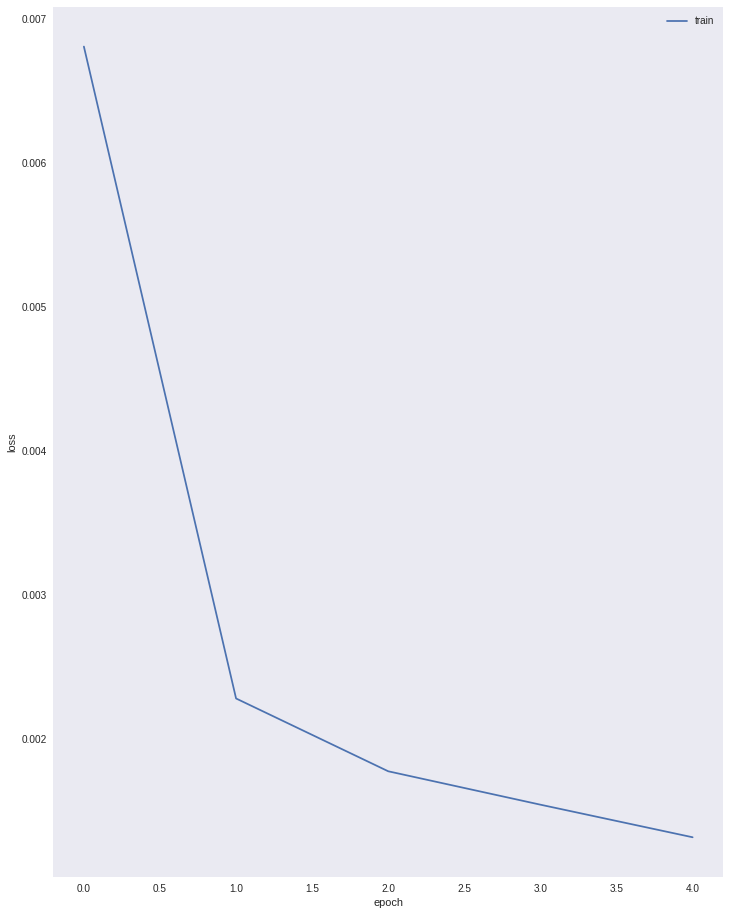

In [26]:
# Uncomment to visualize predictions
plt.plot(fit_model.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'])

In [ ]:
# # Run if loaded saved model from checkpoint
# init = tf.global_variables_initializer()
# sess.run(init)

In [33]:
validation_sample = list(batch_generator(is_training=False))

Found 134 .h5 files and 134 .txt files.
is training? False | number of h5_keys: 130


In [46]:
# Run predictions on development set

with sess.as_default():
    X_development, Y_development = next(batch_generator(is_training=True))
    prediction_batch = model.predict(X_development)
    prediction_batch = prediction_batch.squeeze()
    
    ground_truth_batch = Y_development.squeeze()

Found 134 .h5 files and 134 .txt files.
is training? True | number of h5_keys: 4


/home/ubuntu/cs230/code/MRI_reconstruction_example/cs230_project_utilities/plot.py:13: RuntimeWarning: divide by zero encountered in log10
  imshowgray(20 * np.log10(np.abs(fft)))


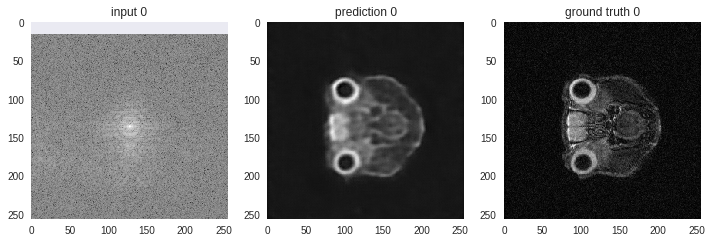

In [47]:
plt.rcParams['image.cmap'] = 'gray' # b/w images

# Prediction 0

mag, phase = X_development[0][..., 0],  X_development[0][..., 1]
fft = mag * np.exp(1j * phase)

# Uncomment to see reconstruction:
# plt.title('Reconstruction')
# utils.plot.imshowgray(np.abs(ifft))

plt.subplot(1, 3, 1)
utils.plot.imshowfft(np.abs(fft))
plt.title('input 0')

plt.subplot(1, 3, 2)
plt.imshow(prediction_batch[0])
plt.title('prediction 0')

plt.subplot(1, 3, 3)
plt.imshow(ground_truth_batch[0])
plt.title('ground truth 0');

/home/ubuntu/cs230/code/MRI_reconstruction_example/cs230_project_utilities/plot.py:13: RuntimeWarning: divide by zero encountered in log10
  imshowgray(20 * np.log10(np.abs(fft)))


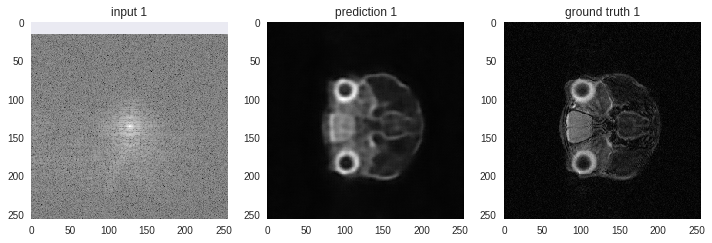

In [48]:
# Prediction 1

mag, phase = X_development[1][..., 0],  X_development[1][..., 1]
fft = mag * np.exp(1j * phase)

plt.subplot(1, 3, 1)
utils.plot.imshowfft(np.abs(fft))
plt.title('input 1')

plt.subplot(1, 3, 2)
plt.imshow(prediction_batch[1])
plt.title('prediction 1')

plt.subplot(1, 3, 3)
plt.imshow(ground_truth_batch[1])
plt.title('ground truth 1');

/home/ubuntu/cs230/code/MRI_reconstruction_example/cs230_project_utilities/plot.py:13: RuntimeWarning: divide by zero encountered in log10
  imshowgray(20 * np.log10(np.abs(fft)))


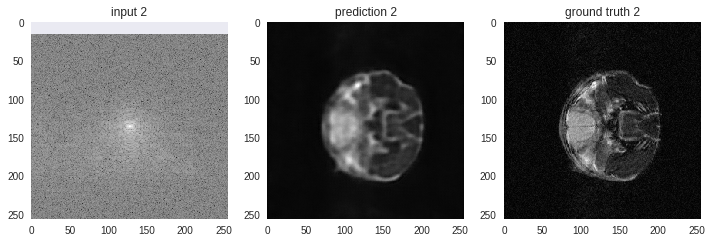

In [49]:
# Prediction 2

mag, phase = X_development[2][..., 0],  X_development[2][..., 1]
fft = mag * np.exp(1j * phase)

plt.subplot(1, 3, 1)
utils.plot.imshowfft(np.abs(fft))
plt.title('input 2')

plt.subplot(1, 3, 2)
plt.imshow(prediction_batch[2])
plt.title('prediction 2')

plt.subplot(1, 3, 3)
plt.imshow(ground_truth_batch[2])
plt.title('ground truth 2');

/home/ubuntu/cs230/code/MRI_reconstruction_example/cs230_project_utilities/plot.py:13: RuntimeWarning: divide by zero encountered in log10
  imshowgray(20 * np.log10(np.abs(fft)))


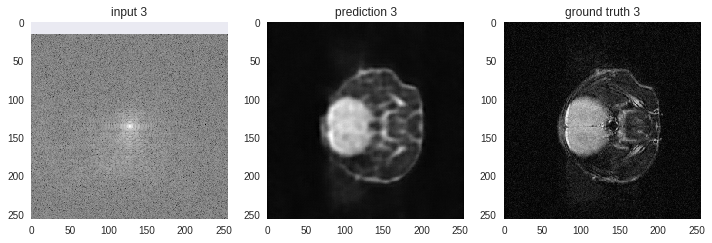

In [50]:
# Prediction 3

mag, phase = X_development[3][..., 0],  X_development[3][..., 1]
fft = mag * np.exp(1j * phase)

plt.subplot(1, 3, 1)
utils.plot.imshowfft(np.abs(fft))
plt.title('input 3')

plt.subplot(1, 3, 2)
plt.imshow(prediction_batch[3])
plt.title('prediction 3')

plt.subplot(1, 3, 3)
plt.imshow(ground_truth_batch[3])
plt.title('ground truth 3');

# NEW

In [288]:
X_batch, Y_batch = next(batch_generator(is_training=True))

Found 134 .h5 files and 134 .txt files.
is training? True | number of h5_keys: 4


In [289]:
X_batch.shape

(16, 256, 256, 2)

In [290]:
Y_batch.shape

(16, 256, 256, 1)

In [318]:
def conv2d(x, W, b, stride, add_bias, activation):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')
    if add_bias:
        x = tf.nn.bias_add(x, b)
    if activation is not None:
        x = activation(x)
    return x

In [319]:
def conv_layer(X, layer_num, filter_size, stride, num_inputs, num_outputs, activation, add_bias):
    W = tf.get_variable("W{}".format(layer_num), [filter_size, filter_size, num_inputs, num_outputs], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
    b = tf.Variable(tf.random_normal([num_outputs]))
    conv = conv2d(X, W, b, stride=stride, add_bias=add_bias, activation=activation)
    return conv

def fully_connected_layer(X, layer_num, num_outputs, activation):
    # maybe add bias
    fc = tf.contrib.layers.fully_connected(
        X,
        num_outputs,
        activation_fn=activation,
        normalizer_fn=None,
        normalizer_params=None,
        weights_initializer=tf.contrib.layers.xavier_initializer(),
        weights_regularizer=None,
        biases_initializer=None,
        biases_regularizer=None,
        reuse=tf.AUTO_REUSE,
        variables_collections=None,
        outputs_collections=None,
        trainable=True,
        scope='fc{}'.format(layer_num))
    return fc

In [320]:
def transposed_conv_layer(X, layer_num, filter_size, stride, num_inputs, output_size, num_outputs, activation, add_bias):
    
    # output_size: [-1, output_size, output_size, num_outputs] (rename to output_channels)
    
    W = tf.get_variable("transposed_conv_W{}".format(layer_num), [filter_size, filter_size, num_outputs, num_inputs],
                        dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
    
    b = tf.Variable(tf.random_normal([num_outputs]))
    
    transposed_conv = tf.nn.conv2d_transpose(
        X,
        W,
        output_shape=[tf.shape(X)[0], output_size, output_size, num_outputs],
        strides=[1, stride, stride, 1],
        padding='SAME',
        name='transposed_conv{}'.format(layer_num)
    )
    
    if add_bias:
        transposed_conv = tf.nn.bias_add(transposed_conv, b)
    
    if activation is not None:
        transposed_conv = activation(transposed_conv)
    
    return transposed_conv



# Automap Model in Tensorflow

In [328]:
def automap_model(X):
    conv1 = conv_layer(X, layer_num=1, filter_size=4, stride=2, num_inputs=2, num_outputs=16, activation=tf.nn.tanh, add_bias=True)
    conv2 = conv_layer(conv1, layer_num=2, filter_size=4, stride=1, num_inputs=16, num_outputs=4, activation=tf.nn.tanh, add_bias=True)
    conv3 = conv_layer(conv2, layer_num=3, filter_size=4, stride=2, num_inputs=4, num_outputs=2, activation=tf.nn.tanh, add_bias=True)

    conv_flattened = tf.contrib.layers.flatten(conv3)

    fc1 = fully_connected_layer(conv_flattened, layer_num=1, num_outputs=4096, activation=tf.nn.tanh)
    fc2 = fully_connected_layer(fc1, layer_num=2, num_outputs=4096, activation=tf.nn.tanh)
    fc2_reshaped = tf.reshape(fc2, [-1, 64, 64, 1])

    conv4 = conv_layer(fc2_reshaped, layer_num=4, filter_size=5, stride=1, num_inputs=1, num_outputs=64, activation=tf.nn.relu, add_bias=True)
    conv5 = conv_layer(conv4, layer_num=5, filter_size=5, stride=1, num_inputs=64, num_outputs=64, activation=tf.nn.relu, add_bias=True)

    transposed_conv1 = transposed_conv_layer(conv5, layer_num=1, filter_size=9, stride=1,
                                             num_inputs=64, output_size=64, num_outputs=64,
                                             activation=tf.nn.relu, add_bias=True)
    transposed_conv2 = transposed_conv_layer(transposed_conv1, layer_num=2, filter_size=9, stride=2,
                                             num_inputs=64, output_size=128, num_outputs=64,
                                             activation=tf.nn.relu, add_bias=True)
    transposed_conv3 = transposed_conv_layer(transposed_conv2, layer_num=3, filter_size=9, stride=2,
                                             num_inputs=64, output_size=256, num_outputs=64,
                                             activation=tf.nn.relu, add_bias=True)

    conv6 = conv_layer(transposed_conv3, layer_num=6, filter_size=1, stride=1,
                       num_inputs=64, num_outputs=1,
                       activation=None, add_bias=True)
    
    return conv6



In [340]:
tf.reset_default_graph()

In [341]:
X = tf.placeholder(tf.float32, [None, 256, 256, 2])
Y = tf.placeholder(tf.float32, [None, 256, 256, 1])

In [342]:
Y_pred = automap_model(X)

In [343]:
loss = tf.reduce_mean(tf.squared_difference(Y, Y_pred))
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

In [344]:
init = tf.global_variables_initializer()

iterations, max_iterations = 0, 3

with tf.Session() as sess:
    sess.run(init)
    
    for X_batch, Y_batch in batch_generator(is_training=True):
        
        _, current_loss, y = sess.run([optimizer, loss, Y_pred], {X: X_batch, Y: Y_batch})
        
        print(current_loss)
        
        iterations += 1
        
        if iterations > max_iterations:
            break

Found 134 .h5 files and 134 .txt files.
is training? True | number of h5_keys: 4
1.6116594
0.80056703
0.34124246
0.09924969
